# this notebook represents long-term forecasting(until 2024) with monthly resolution using weighted average ensemble 

In [ ]:

from numpy import argsort
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import VotingRegressor
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
import sklearn
from sklearn import metrics
import numpy as np
import matplotlib.dates as mdates

In [ ]:
#read multivariate data
df=pd.read_csv('/content/forecasting_until_2024.csv')
df.time=pd.to_datetime(df.time,dayfirst=True)
df.columns

Index(['time', 'MIN_TEMPERATURE_C_t_36', 'max_clients_month_t_36',
       'total_Holiday_Food_Related_t_36', 'total_consommation_t_36',
       'max_pdl_total_daily_load_t_36', 'max_pdl_daily_load_t_36',
       'MIN_TEMPERATURE_C_t', 'max_clients_month_t',
       'total_Holiday_Food_Related_t', 'max_pdl_daily_load_t'],
      dtype='object')

In [ ]:
data=pd.read_csv('/content/forecasting_until_2024.csv',
                 index_col='time')[['MIN_TEMPERATURE_C_t_36', 'max_clients_month_t_36',
       'total_Holiday_Food_Related_t_36', 'total_consommation_t_36',
       'max_pdl_total_daily_load_t_36', 'max_pdl_daily_load_t_36',
       
       'MIN_TEMPERATURE_C_t', 'max_clients_month_t',
       'total_Holiday_Food_Related_t', 'max_pdl_daily_load_t']].dropna()


In [ ]:
data.shape

(75, 10)

In [ ]:
data.index=pd.to_datetime(data.index,dayfirst=True)

In [ ]:
data.head()

,MIN_TEMPERATURE_C_t_36,max_clients_month_t_36,total_Holiday_Food_Related_t_36,total_consommation_t_36,max_pdl_total_daily_load_t_36,max_pdl_daily_load_t_36,MIN_TEMPERATURE_C_t,max_clients_month_t,total_Holiday_Food_Related_t,max_pdl_daily_load_t
time,,,,,,,,,,
2018-01-31,8.0,3980.0,2.0,247497.63,22257.0,1479.0,11.0,4869.0,1.0,1447.0
2018-02-28,11.0,4023.0,0.0,263249.88,22242.0,1494.0,11.0,4901.0,0.0,1472.0
2018-03-31,12.0,4060.0,0.0,246311.89,21691.0,1551.0,11.0,4943.0,0.0,1307.0
2018-04-30,14.0,4094.0,0.0,237177.99,16752.0,1253.0,15.0,4964.0,0.0,1232.0
2018-05-31,19.0,4112.0,0.0,229106.03,12318.0,1123.0,17.0,5020.0,15.0,1494.0


In [ ]:
data.tail()

,MIN_TEMPERATURE_C_t_36,max_clients_month_t_36,total_Holiday_Food_Related_t_36,total_consommation_t_36,max_pdl_total_daily_load_t_36,max_pdl_daily_load_t_36,MIN_TEMPERATURE_C_t,max_clients_month_t,total_Holiday_Food_Related_t,max_pdl_daily_load_t
time,,,,,,,,,,
2023-11-30,20.0,5736.676233,0.0,284287.81,20677.0,1443.0,15.236175,6127.384238,0.0,0.0
2023-12-31,23.0,5736.676233,0.0,313725.30,28868.0,1628.0,10.631705,6127.384238,0.0,0.0
2024-01-31,24.0,5736.676233,0.0,249158.97,29644.0,1696.0,7.363303,6127.384238,0.0,0.0
2024-02-28,19.0,5767.319998,0.0,222261.04,25218.0,1604.0,5.626715,6127.384238,0.0,0.0
2024-03-31,16.0,5807.539940,0.0,219707.61,26706.0,1601.0,6.241679,6127.384238,21.0,0.0


# make future forecasts until 2024 using the best performing model: weighted ensemble model which has a winter MAPE equal to 1.55%



*   Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None,normalize=False, random_state=None, solver='lsqr', tol=0.001)
*   SVR(C=1.5, cache_size=200, coef0=0.0, degree=1, epsilon=1e-05, gamma='auto',kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)



In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [ ]:
features=data_scaled[:,:-1]
target=data_scaled[:,-1]

In [ ]:
# split into train and test sets

n_train_days = 44 #n_train_months

X_train,y_train = features[:n_train_days, :],target[:n_train_days]
X_test, y_test = features[n_train_days:, :],target[n_train_days:]



In [ ]:
# get a list of base models
def get_models():
  models = list()
  models.append(('ridge', Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None,
                                normalize=False, random_state=None, solver='lsqr', tol=0.001)))

  models.append(('svr', SVR(C=1.5, cache_size=200, coef0=0.0, degree=1, epsilon=1e-05, gamma='auto',
                            kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)))
  return models


https://colab.research.google.com/drive/1frLBCHhNaBnkliLLatq-C_EPnRcfGqXd

In [ ]:
##############
# create the base models
models = get_models()
###############
# create the ensemble
#weights of the ensembling model were determined in the notebook of the link above
weighted_ensemble = VotingRegressor(estimators=models, weights=[2,1])
# fit the ensemble on the training dataset: until 08-2021 (max date of PDL data)
weighted_ensemble.fit(X_train, y_train)
# make predictions on test set
weighted_yhat = weighted_ensemble.predict(X_test)
yhat=weighted_yhat.reshape(weighted_yhat.shape[0],1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))
inv_yhat = concatenate((X_test,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
weighted_inv_yhat = inv_yhat[:,-1]




In [ ]:
#print the max value of the forecasted gas peak demand
print(weighted_inv_yhat.max())
print(weighted_inv_yhat.argmax())
#the max value of the forecasting happens in March 2024 

1916.9412200419283
30


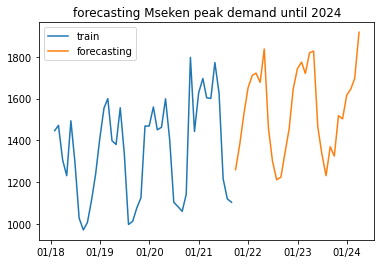

In [ ]:
# plot baseline and predictions
time=data.index
#plt.plot(time,inv_y,label='actual')
plt.plot(time[:44],data['max_pdl_daily_load_t'][:44],label="train")
plt.plot(time[44:],weighted_inv_yhat,label="forecasting")
plt.title('forecasting Mseken peak demand until 2024')
plt.legend()
locator = mdates.AutoDateLocator()
fmt = mdates.DateFormatter('%m/%y')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.show()